<a href="https://colab.research.google.com/github/cle7jhu/530-391-13/blob/master/bdms_project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!wget https://raw.githubusercontent.com/tidyverse/ggplot2/master/data-raw/diamonds.csv;
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv;
!ls

--2020-09-29 22:40:29--  https://raw.githubusercontent.com/tidyverse/ggplot2/master/data-raw/diamonds.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2772143 (2.6M) [text/plain]
Saving to: ‘diamonds.csv’

diamonds.csv        100%[===================>]   2.64M  10.3MB/s    in 0.3s    

2020-09-29 22:40:29 (10.3 MB/s) - ‘diamonds.csv’ saved [2772143/2772143]

--2020-09-29 22:40:29--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


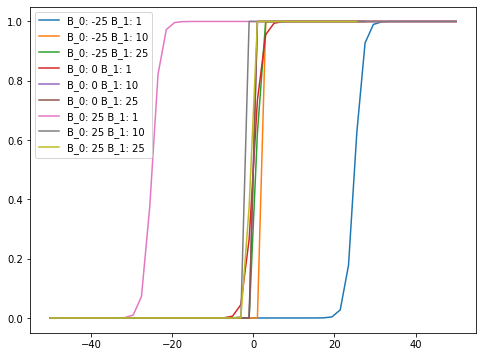

In [2]:
#Question 1 just play around with logistic curves
B_0 = [-25, 0, 25]
B_1 = [1, 10 ,25]
x = np.linspace(-50,50,50)
plt.figure(figsize=(8, 6))
for i in range(len(B_0)):
  for j in range(len(B_1)):
    y = B_1[j]*x + B_0[i]
    plt.plot(x,np.exp(y)/(1+np.exp(y)),label = 'B_0: {} B_1: {}'.format(B_0[i],B_1[j]))

plt.legend()

In [3]:
# Fit a linear regression of price as a function of color, cut, clarity, carat
df = pd.read_csv('diamonds.csv')
#Data PreProcessing
#convert cut, color, clarity into one hot encoded
color_OH = pd.get_dummies(df.color)
cut_OH = pd.get_dummies(df.cut)
clarity_OH = pd.get_dummies(df.clarity)

#split into train and test data
N = len(df.carat) #number of samples
np.random.seed(seed = 10)
order = np.linspace(0,N-1,N,dtype=int)
np.random.shuffle(order)
idx_train = order[:int(np.round(N*.75))]
idx_test = order[int(np.round(N*.75)):]

#build features X by horizontal concenating carat and one hot encoded arrays 
X = np.concatenate((df.carat.to_numpy().reshape((N,1)),color_OH.to_numpy(),cut_OH.to_numpy(),clarity_OH.to_numpy()),axis=1) 
#split into train and test for X and Y
X_train = X[idx_train] 
X_test = X[idx_test]
Y = df.price.to_numpy()
Y_train = Y[idx_train]
Y_test = Y[idx_test]

#Perform Linear Regression on training data
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, Y_train)

# #calculate root of mean squared error from testing data
from sklearn.metrics import mean_squared_error
Y_pred=reg.predict(X_test)
MSE = mean_squared_error(Y_test, Y_pred)
print('The root of the mean squared error for this linear regression model is {}'.format(np.sqrt(MSE)))

The root of the mean squared error for this linear regression model is 1149.989371861707


In [16]:
df = pd.read_csv("time_series_covid19_confirmed_global.csv") #get confirmed cases 
df = df.drop(['Lat','Long','Province/State'],axis=1) #remove unused headers
df = df[df['Country/Region'] == "Finland"]
ts_df = df.T
ts_df.columns = ts_df.iloc[0]
ts_df = ts_df.drop('Country/Region')
ts_df = ts_df.assign(idx = np.arange(len(ts_df))) #create index column for ease of use
day1 = np.nonzero(np.asarray(ts_df['Finland']))[0][0] #find first day 
ts_df = ts_df.assign(new = ts_df['Finland'].diff()) #create column for new cases
ts_df = ts_df.assign(Y = [1 if ts_df['new'].diff()[i] > 0 else 0 for i in range(len(ts_df['new']))]) #defining Y as 1 for an increase in new cases from the previous day

#build a logit regression 
#Partition test and train cases
N = len(ts_df['Y'][day1+4:-4]) #number of samples
print(N)
np.random.seed(seed = 10)
order = np.linspace(0,N-5,N-4,dtype=int) #minus the first 4 days since there will be no value for that
np.random.shuffle(order)
idx_train = order[:int(np.round(N*.75))]
idx_test = order[int(np.round(N*.75)):]
#Define Y and X matricies for past the first 4 days
Y = ts_df['Y'][day1+1:].to_numpy()[3:]
y_train = Y[idx_train]
y_test = Y[idx_test]
new = ts_df['new'][day1+1:].to_numpy().reshape((len(ts_df['new'][day1+1:]),1))
X = np.concatenate((new[3:-1], new[2:-2],new[1:-3],new[0:-4] ),axis=1)[3:]
X_train = X[idx_train]
X_test = X[idx_test]
#Perform logistic regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
#calculate accuracy
acc = 0.0
for i in range(len(y_pred)):
  if y_pred[i] == y_test[i]:
    acc+=1
acc = acc/len(y_pred)
print('The country forecasting accuracy for Finland is {}'.format(acc))
#Part 2: Train on Germany, apply to Finland

#Get Germany data 
df = pd.read_csv("time_series_covid19_confirmed_global.csv") #get confirmed cases 
df = df.drop(['Lat','Long','Province/State'],axis=1) #remove unused headers
df = df[df['Country/Region'] == "Germany"]
ger_df = df.T
ger_df.columns = ger_df.iloc[0]
ger_df = ger_df.drop('Country/Region')
ger_df = ger_df.assign(idx = np.arange(len(ger_df))) #create index column for ease of use
day1 = np.nonzero(np.asarray(ger_df['Germany']))[0][0] #find first day 
print(day1)
ger_df = ger_df.assign(new = ger_df['Germany'].diff()) #create column for new cases
ger_df = ger_df.assign(Y = [1 if ger_df['new'].diff()[i] > 0 else 0 for i in range(len(ger_df['new']))]) #defining Y as 1 for an increase in new cases from the previous day

#Define Y and X matricies for past the first 4 days
ger_Y = ger_df['Y'][day1+4:-4].to_numpy()
new = ger_df['new'][day1+1:].to_numpy().reshape((len(ger_df['Y'][day1+1:]),1))
ger_X = np.concatenate((new[3:-1], new[2:-2],new[1:-3],new[0:-4] ),axis=1)[3:]

#Train logistic regression using germany data
clf = LogisticRegression(random_state=0).fit(ger_X, ger_Y)
y_pred2 = clf.predict(X) 
#calculate accuracy
acc = 0.0
for i in range(len(y_pred2)):
  if y_pred2[i] == Y[i]:
    acc+=1
acc = acc/len(Y)
print('The between country forecasting accuracy for Finland using all of Germanys data is {}'.format(acc))

240
The country forecasting accuracy for Finland is 0.6785714285714286
5
The between country forecasting accuracy for Finland using all of Germanys data is 0.5541666666666667


In [11]:
print(ts_df.head(20))

Country/Region Finland  idx  new  Y
1/22/20              0    0  NaN  0
1/23/20              0    1    0  0
1/24/20              0    2    0  0
1/25/20              0    3    0  0
1/26/20              0    4    0  0
1/27/20              0    5    0  0
1/28/20              0    6    0  0
1/29/20              1    7    1  1
1/30/20              1    8    0  0
1/31/20              1    9    0  0
2/1/20               1   10    0  0
2/2/20               1   11    0  0
2/3/20               1   12    0  0
2/4/20               1   13    0  0
2/5/20               1   14    0  0
2/6/20               1   15    0  0
2/7/20               1   16    0  0
2/8/20               1   17    0  0
2/9/20               1   18    0  0
2/10/20              1   19    0  0
